# Prueba Claro
## Frank Montenegro - frandak2@gmail.com

### importamos las librerias que vamos a usar

In [1]:
import pandas as pd
import geopandas as gpd
import libpysal as lp
import matplotlib.pyplot as plt
import seaborn as sns
import geoplot as gplt
import geoplot.crs as gcrs
import plotly.express as px
import rasterio as rio
import numpy as np
import contextily as ctx
import shapely.geometry as geom
import folium
import folium.plugins as plugins
import os
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')# Configuración warnings

### redireccionamos la ruta del notebook

In [2]:
# import os
g = os.getcwd()
g
path = r'D:\repos\PRUEBA_GEO'
os.chdir(path)

## Procedemos a leer los archivos shapefile
de antemanos sabemos que el shape MGN es la capa de centros poblados del igac, en este shape tenemos imforacion sobre la forma, tamanio y area de cada centro poblado del pais

In [3]:
Comparendos = gpd.read_file("data/Comparendos_2019_Bogota_D_C-shp/comparendos_corregido.shp")


## Que podemos averiguar con este dataset
### - crear un mapa del total de comparendos mensuales por localidad?
### - crear un densidad de comparendos anual?

In [4]:
Comparendos['FECHA_HORA'] = pd.to_datetime(Comparendos['FECHA_HORA'])## transformamos la columna fecha
Comparendos['MES'] = pd.Categorical(Comparendos['MES'], categories=[ 'ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO', 'JULIO', 'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE', 'DICIEMBRE'], ordered=True)
Comparendos.head(5)

,FECHA_HORA,MES,MEDIO_DETE,CLASE_VEHI,TIPO_SERVI,INFRACCION,DES_INFRAC,MUNICIPIO,LATITUD,LONGITUD,CANTIDAD,LOCALIDAD,geometry
0,2019-01-01,ENERO,DEAP,AUTOMÓVIL,Particular,C02,ESTACIONAR UN VEHÍCULO EN SITIOS PROHIBIDOS.,BOGOTA,4.750385,-74.088710,1,SUBA,POINT (998757.245 1017049.995)
1,2019-01-01,ENERO,DEAP,AUTOMÓVIL,Particular,C02,ESTACIONAR UN VEHÍCULO EN SITIOS PROHIBIDOS.,BOGOTA,4.750385,-74.088710,1,SUBA,POINT (998757.245 1017049.995)
2,2019-01-01,ENERO,DEAP,AUTOMÓVIL,Particular,C02,ESTACIONAR UN VEHÍCULO EN SITIOS PROHIBIDOS.,BOGOTA,4.750467,-74.088823,1,SUBA,POINT (998744.709 1017059.063)
3,2019-01-01,ENERO,DEAP,AUTOMÓVIL,Particular,C02,ESTACIONAR UN VEHÍCULO EN SITIOS PROHIBIDOS.,BOGOTA,4.750358,-74.088554,1,SUBA,POINT (998774.551 1017047.009)
4,2019-01-01,ENERO,DEAP,AUTOMÓVIL,Público,C02,ESTACIONAR UN VEHÍCULO EN SITIOS PROHIBIDOS.,BOGOTA,4.736974,-74.082732,1,SUBA,POINT (999420.431 1015566.974)


## Leemos el shape file de localidades para poder hacer un analisis por localidades

In [5]:
##lectura de localidades
local_BGT = gpd.read_file('data\localidades\localidades.shp')
local_BGT.to_crs(epsg=4326, inplace=True)
local_BGT = local_BGT[['NOMBRE','geometry']]
local_BGT.columns = ['LOCALIDAD','geometry']
local_BGT.head(5)

,LOCALIDAD,geometry
0,SANTA FE,"POLYGON ((-74.06856 4.62792, -74.06841 4.62880..."
1,PUENTE ARANDA,"POLYGON ((-74.11830 4.63741, -74.11504 4.64053..."
2,CIUDAD BOLIVAR,"POLYGON ((-74.15216 4.59976, -74.15218 4.59925..."
3,BARRIOS UNIDOS,"POLYGON ((-74.05725 4.68684, -74.06249 4.65594..."
4,SUBA,"POLYGON ((-74.04245 4.83066, -74.04242 4.83063..."


In [ ]:
sum_total = Comparendos.groupby(['LOCALIDAD'])['CANTIDAD'].sum().reset_index()#contamos los numeros de casos de comparendos por localidad
count_local = sum_total.merge(local_BGT,how='inner', on='LOCALIDAD')#unimos la geometria con la la localidad correspondiente
count_local = gpd.GeoDataFrame(count_local)# se transforma a geopd
count_local.plot(column='CANTIDAD', cmap='BuPu',legend=True,figsize=(10,10))#ploteamos el mapa anual de casos de comaprendos
plt.title('Mapa de localidades con mayor comparendos en BOGOTA - 2019')# le colocamos el titulo

## Para poder aterrizar mejor el analisis haremos la mismas visualizacion pero por mes para ver su comportamiento

In [ ]:
sum_mes = Comparendos.groupby(['MES','LOCALIDAD'])['CANTIDAD'].sum().reset_index()#contamos por localidad y mes los casos de comparendos


In [ ]:
count_local = sum_mes.merge(local_BGT,how='inner', on='LOCALIDAD')
count_local = gpd.GeoDataFrame(count_local)


In [ ]:
fig, axes = plt.subplots(1,12, figsize=(40,40),sharex=True, sharey=True)
for fid, mes in enumerate(count_local.MES.unique()):
    meses = count_local[count_local['MES']==mes]
    axes[fid].set_title(mes)
    meses.plot(ax=axes[fid], column='CANTIDAD', cmap='BuPu', legend=True)

Con el grafico anterior podemos sacar muchas conclusiones como saber cual es la localida de mayor afectacion y demas afirmaciones, pero estariamos desaporvechando la informacion espacial, ya que podriamos saber que zonas de esas localidades son las mas afectadas.
## por este motivo crearemos un hotplot mensual y de esta forma tener mayor informacion.
### para esto tenemos varias opciones de visualizacion, como plotly, folium, incluso hacerlo con GEE(Google Earth Engine) o usar pyQGIS

In [ ]:
token = 'pk.eyJ1IjoiZnJhbmRhazIiLCJhIjoiY2t0cHpubW1jMDlmdzJvbXhjZ2o0eHc0ZiJ9.WiHLSWVwG9VYcmBLls4oDg' ## token para usar plotly
px.set_mapbox_access_token(token)#acceder con token

In [ ]:
## mapa de densidad usando plotly, son mapas dinamicos que nos ayudan a ver rapidamente que ocurre con nuestros datos
px.density_mapbox(data_frame=Comparendos,
                lat='LATITUD',
                lon='LONGITUD',
                z='CANTIDAD',
                hover_name='LOCALIDAD',
                color_continuous_scale=px.colors.cyclical.IceFire,
                zoom=10,
                radius=5)


In [ ]:
## acomodamos los datos degun las necesidades de la funciones de folium, ya que recibe una lista de cordenadas por fecha
fecha = Comparendos[['LATITUD','LONGITUD','CANTIDAD','FECHA_HORA']]
fecha = fecha.groupby('FECHA_HORA')
array=[]
time_index=[]
for key, group in fecha:
    time_index.append(str(key))
    array.append(np.array(group[['LATITUD','LONGITUD','CANTIDAD']]))
array = [i.tolist() for i in array]

In [ ]:
## creamos un mapa con folium que sea dinamico para ver el hotsplot por dia de nuestros datos.
m = folium.Map([4.6, -74.0], tiles="stamentoner", zoom_start=12)# mapa base

hm = plugins.HeatMapWithTime(array, index=time_index, auto_play=True, max_opacity=0.3) #heatmap diario y con auto play

hm.add_to(m)# lo agregamos al mapa base

m # lo publicamos o mostramos

## estos mapas son dinamicos y nos ayudan a mostrar de forma rapida que puede suceder con nuestros datos, pero que ocurre cuand deseamos operar con esta informacion? pues para eso tenemos muchas herramientas como usar OGR, GDAL o QGIS puro para crear esto mapas de calor o densidad

In [ ]:
# creamos un heatmap dede geoplot
mes = Comparendos[Comparendos['MES']=='ENERO'][['CANTIDAD', 'geometry']]

kdeplot(mes,)
# Add polygons
polyplot(local_BGT, ax=ax)


In [ ]:
MES = Comparendos[['CANTIDAD','MES', 'geometry']]
MES = MES.groupby('MES')
for key, group in MES:
    group['MES'] = group['MES'].astype(str) 
    group.to_file(r'D:\repos\Prueba_Geo\data\MESES\{}.shp'.format(key))# creamos un shp mensual de comparendos
    print('mi ruta: ',r'D:\repos\Prueba_Geo\data\MESES\{}.shp'.format(key))
    

In [ ]:
from qgis import processing
from pathlib import Path

p = Path(r'D:\repos\Prueba_Geo\data\MESES').glob('*.shp')
files = [x for x in p if x.is_file()]
out = [i.with_suffix('.tif') for i in files]
for shp,tif, in zip(files,out):
    print(shp,tif)
    # Parámetros de entrada:
    parameter = {
    'INPUT' : shp, # lectura del shape
    'OUTPUT' : tif, #escritura del raster
    'PIXEL_SIZE' : 1, # tamano del pixel, un metro en nuestro caso hay que tener mucho cuidado con esto ya que dependiendo de tu pc o la nube podria tener un alto consto computacional
    'RADIUS' : 10, # usa un radio de 10 metros
    'WEIGHT_FIELD' : 'CANTIDAD' # el campo de peso para la interpolacion }
    
    processing.run("qgis:heatmapkerneldensityestimation",parameter)

In [ ]:
heatmap_enero = rio.open(r'D:\repos\Prueba_Geo\data\MESES\ENERO.tif')
heat = heatmap_enero.read(1)
print(heatmap_enero.shape)
print(heatmap_enero.crs)

In [ ]:
from rasterio import plot as rioplot
rioplot.show(heat, cmap='hot')

## con estos mapas podriamos ahcer diversas operaciones como sumarlos para ver frecuencias en el ano o sacar las vias con mayor indice de comparendo, tambien podriamos hacer un subset de equipamentos para ver la relacion entre los tipos de equipamentos y el indice de comparendos, y todo esto lo podemos hacer a una escla diaria, semana, mensual y anual.

# ahora hallaremos los cluster a nivel mensual, utilizando Kmeans, nos ayudara a clasificar cada punto dentro un grupo para ver si hay patrones espaciales

In [6]:
MES = Comparendos[['CANTIDAD','MES', 'geometry']]
MES = MES.groupby('MES')
for key, group in MES:
    gdf = MES.get_group(key)
    gdf['MES'] = gdf['MES'].astype(str) 
    a=pd.Series(gdf['geometry'].apply(lambda p: p.x))
    b=pd.Series(gdf['geometry'].apply(lambda p: p.y))
    X=np.column_stack((a,b))

In [7]:
gdf

,CANTIDAD,MES,geometry
18218,1,DICIEMBRE,POINT (995812.865 1016285.094)
18219,1,DICIEMBRE,POINT (1002080.700 1015727.233)
18220,1,DICIEMBRE,POINT (997661.170 1017357.991)
18221,1,DICIEMBRE,POINT (997620.675 1017270.412)
18222,1,DICIEMBRE,POINT (997918.542 1017068.038)
...,...,...,...
400453,1,DICIEMBRE,POINT (996525.200 998463.723)
400454,1,DICIEMBRE,POINT (995559.716 997039.483)
400455,1,DICIEMBRE,POINT (994725.781 996882.618)
400456,1,DICIEMBRE,POINT (994691.381 996889.698)


### Usaré el método del ELBOW para determinar el número óptimo de grupos.

In [31]:
from sklearn.cluster import MiniBatchKMeans as KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def train_elbow_cluster(train,start=1,finish=10,each=1):
    wcss = {} #dicionario vacio para guardar los errores
    train = scaler.fit_transform(train)
    for i in range(start,finish,each):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        kmeans.fit(train)
        wcss[i] = kmeans.inertia_ #suma de distancias cuadradas a los centros del grupos más cercanos
    plt.title('Metodo de Elbow ')
    plt.xlabel('k= n grupos')
    plt.ylabel('WCSS')
    sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
    plt.show()
    return wcss


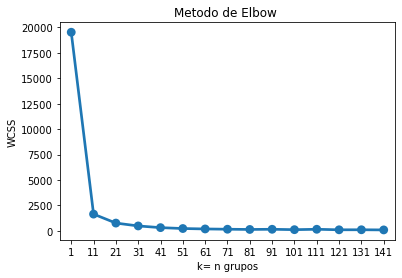

{1: 19532.84620932599,
 11: 1638.2409773287777,
 21: 754.5769218477747,
 31: 472.9720220897062,
 41: 306.172857442996,
 51: 218.68083715973412,
 61: 177.14355717175064,
 71: 150.08107078903865,
 81: 127.51273214941048,
 91: 145.0441134806889,
 101: 105.67139509753913,
 111: 145.44415660709907,
 121: 93.64673925127326,
 131: 97.14995404017844,
 141: 81.95532121778022}

In [32]:
train_elbow_cluster(X,finish=150,each=10)

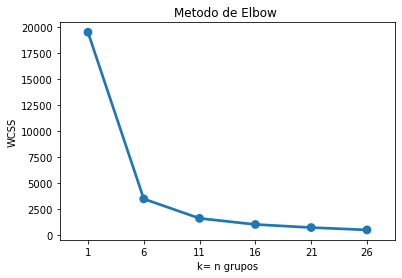

{1: 19532.84620932599,
 6: 3507.8288680205974,
 11: 1638.2409773287777,
 16: 1052.0559642617832,
 21: 754.5769218477747,
 26: 527.3677978993954}

In [33]:
train_elbow_cluster(X,finish=30,each=5)


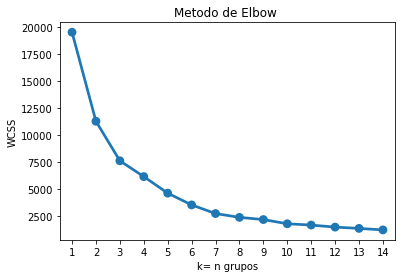

{1: 19532.84620932599,
 2: 11272.618898567222,
 3: 7602.771536692408,
 4: 6135.2752678506085,
 5: 4600.482733716014,
 6: 3507.8288680205974,
 7: 2707.1964401156856,
 8: 2352.0769145494996,
 9: 2149.367549141702,
 10: 1758.471211735241,
 11: 1638.2409773287777,
 12: 1447.6730175622706,
 13: 1329.3795581311192,
 14: 1187.759969459527}

In [34]:
train_elbow_cluster(X,finish=15,each=1)

In [36]:
kmeans = KMeans(n_clusters = 11, init = 'k-means++', random_state = 42,  max_iter=400)
X = scaler.fit_transform(X)
y_kmeans = kmeans.fit_predict(X)
gdf['cluster']=y_kmeans

Text(0.5, 1.0, 'cluster del mes 2010')

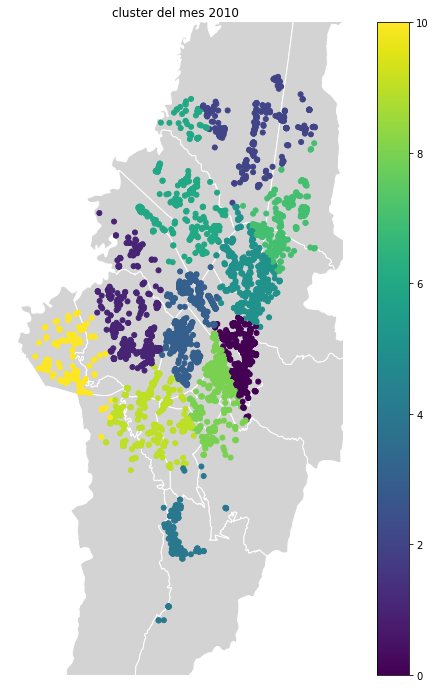

In [37]:
gdf.to_crs(epsg=4326, inplace=True)

ax = gplt.polyplot(
    local_BGT,
    zorder=-1,
    linewidth=1,
    projection=gcrs.Mollweide(),
    edgecolor='white',
    facecolor='lightgray',
    figsize=(12, 12)
)
gplt.pointplot(
    gdf,
    hue='cluster',
    legend=True, legend_var='hue',
    ax=ax
)

plt.title("cluster del mes 2010")

In [39]:
gdf

,CANTIDAD,MES,geometry,cluster
18218,1,DICIEMBRE,POINT (-74.11525 4.74347),6
18219,1,DICIEMBRE,POINT (-74.05875 4.73842),2
18220,1,DICIEMBRE,POINT (-74.09859 4.75317),2
18221,1,DICIEMBRE,POINT (-74.09895 4.75238),2
18222,1,DICIEMBRE,POINT (-74.09627 4.75055),2
...,...,...,...,...
400453,1,DICIEMBRE,POINT (-74.10882 4.58231),9
400454,1,DICIEMBRE,POINT (-74.11752 4.56943),9
400455,1,DICIEMBRE,POINT (-74.12504 4.56801),9
400456,1,DICIEMBRE,POINT (-74.12535 4.56807),9


In [ ]:
import libpysal
import esda

weights = libpysal.weights.Queen.from_dataframe(mergedData)  # generate spatial weights (Queen in this case)
spatial_auto = esda.Moran(mun[['population']], weights)  # calculate Moran's I